This is a jupyter notebook to create a  new dataset of representetive graphs from shape data.

In [1]:
import matplotlib
import random
from matplotlib import pyplot as plt
import glob
import os
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point, MultiPoint, Polygon, shape
from shapely.geometry.multilinestring import MultiLineString
from shapely.geometry.linestring import LineString
from shapely.geometry.collection import  GeometryCollection 
from shapely.affinity import translate
from shapely.ops import triangulate
import pandas as pd
import numpy as np
from shapely import ops
import pickle
from earthpy import clip as cl

## Objective
This notebook goes through the process of creation of graphs from a shp data from the BD TOPO by IGN (http://www.ign.fr)

# 2004

First of all, specify the data from BD topo to load: they should be in the shp format.

In [2]:
global_path = "D:/IGN_data/BD/2004/BDTOPO/1_DONNEES_LIVRAISON_2019-06-00227/"

script to find all the interesting objects and create polygons around them. Simply goest through all the special buildings, finds centroid and creates a polyon around them. The resulting polygons are then saved in 'image_polygons.shp'  file.

In [3]:
# special buildings
fp_remk = global_path +"BDT_2-0_SHP_LAMB93_D057-ED083/E_BATI/BATI_REMARQUABLE.shp"
buildings3 = gpd.read_file(fp_remk)
buildings3.NATURE.unique()

array(['Aérogare', 'Gare', 'Mairie', 'Péage', 'Préfecture',
       'Bâtiment religieux divers', 'Sous-préfecture', 'Bâtiment sportif',
       'Tour, donjon, moulin', 'Chapelle', 'Eglise', 'Tribune', 'Château',
       'Fort, blockhaus, casemate', 'Monument'], dtype=object)

In [6]:
# go through all the unique buildings, get the centers of their coordinates and create polygons which are centered around it (+/- with a random threshold)
image_polygons = buildings3.copy()
for bati in  range(len(buildings3)):
    center = buildings3.geometry[bati].centroid
    shifted_center = Point(center.x + random.randrange(-10, +10),center.y + random.randrange(-10, +10))
    polygon1 = Polygon([[shifted_center.x-100, shifted_center.y-100], [shifted_center.x+100, shifted_center.y-100], [shifted_center.x+100, shifted_center.y+100], [shifted_center.x-100, shifted_center.y+100]])
    image_polygons.geometry[bati] = polygon1
#save resulting polygons as a shape file
image_polygons.to_file('image_polygons.shp', driver='ESRI Shapefile')

## Graph creation

### Data loaders
We now need to load al the data which will be used for graph creation in the next steps.


#### ROADS & RIVERS

In [3]:
# load all the shapely files related to ROADS
fp_road = global_path + "BDT_2-0_SHP_LAMB93_D057-ED083/A_RESEAU_ROUTIER/cleaned_road_network.shp"
data_road_troncon =  gpd.read_file(fp_road)
all_roads = data_road_troncon
fp_water =  global_path +"BDT_2-0_SHP_LAMB93_D057-ED083/D_HYDROGRAPHIE/TRONCON_COURS_EAU.shp"
all_water = gpd.read_file(fp_water)

### Houses & BATI

In [4]:
# Load all the data from the BUILDINGS caegory
fp_bati =  global_path +"BDT_2-0_SHP_LAMB93_D057-ED083/E_BATI/BATI_INDIFFERENCIE.shp"
fp_inds =global_path +"BDT_2-0_SHP_LAMB93_D057-ED083/E_BATI/BATI_INDUSTRIEL.shp"

# Read file using gpd.read_file()
buildings1= gpd.read_file(fp_bati)
buildings2 =gpd.read_file(fp_inds)

# concaenate the buildings into a single table
all_buildings =  pd.concat([buildings1, buildings2],ignore_index=True ) # concatenate all the buildings together

### Remarcable buildings

In [5]:
# special buildings
fp_remk = global_path +"BDT_2-0_SHP_LAMB93_D057-ED083/E_BATI/BATI_REMARQUABLE.shp"
buildings3 = gpd.read_file(fp_remk)
churches = buildings3.loc[(buildings3['NATURE'] == "Eglise") | (buildings3['NATURE'] == "Chapelle") | (buildings3['NATURE'] =="Bâtiment religieux divers")]

towers = buildings3.loc[(buildings3['NATURE'] == "Tour, donjon, moulin") | (buildings3['NATURE'] == 'Arc de triomphe')]
monuments = buildings3.loc[buildings3['NATURE'] == "Monument"]  
forts = buildings3.loc[buildings3['NATURE'] == 'Fort, blockhaus, casemate']
castels =buildings3.loc[buildings3['NATURE'] =='Château']

public_buildings = buildings3.loc[(buildings3['NATURE'] == "Préfecture") | (buildings3['NATURE'] == "Mairie") |
                                   (buildings3['NATURE'] =="Sous-préfecture")]
sport_buldings = buildings3.loc[(buildings3['NATURE'] =="Bâtiment sportif") | (buildings3['NATURE'] =="Tribune")]
gares = buildings3.loc[buildings3['NATURE'] =="Gare"]
normal_buldings = buildings3.loc[(buildings3['NATURE']== "Bâtiment religieux divers") |(buildings3['NATURE'] =="Aérogare") | (buildings3['NATURE'] =="Péage") ]
all_buildings =  pd.concat([all_buildings, normal_buldings],ignore_index=True )                                                                                        

In [6]:
# delete possible dublicates, when special buildings are also marked as usual buildings (it happens sometimes)
result = pd.concat([churches, towers, monuments, forts, castels,sport_buldings, public_buildings,gares],ignore_index=True )  
all_buildings= all_buildings.loc[pd.merge(all_buildings,result, on=['ID'], how='left', indicator=True)['_merge'] == 'left_only']

### SPORT TERRITORIES

In [7]:
fp_sport =global_path +"BDT_2-0_SHP_LAMB93_D057-ED083/E_BATI/TERRAIN_SPORT.shp"
data_sport = gpd.read_file(fp_sport)


### CEMETRIES

In [8]:
fp_cemetries = global_path +"BDT_2-0_SHP_LAMB93_D057-ED083/E_BATI/CIMETIERE.shp"
data_cemetries = gpd.read_file(fp_cemetries)

### AERODROMES & RAILROADS

In [9]:
fp_aero = global_path + "BDT_2-0_SHP_LAMB93_D057-ED083/E_BATI/PISTE_AERODROME.shp"
data_aero = gpd.read_file(fp_aero)
fp_rail = global_path + "BDT_2-0_SHP_LAMB93_D057-ED083/B_VOIES_FERREES_ET_AUTRES/TRONCON_VOIE_FERREE.shp"
data_rail  = gpd.read_file(fp_rail)

### BOUNDING BOXES FOR THE GRAPHS


Load the pre-calculated bounding boxes from the step 1

In [10]:
image_polygons = gpd.read_file('D:/IGN_data/BD/image_polygons.shp')

## Graph creation

In [17]:
# load all the helper functions created for graphs
from helper_functions import calculate_eccentricity,  calculate_centroids, calculate_perimeter, get_node_attributes, determine_if_connected, clean_and_append

In [12]:
def create_graph_where_object_is_node(gp_frame, poly = None):
    ''' function takes the pandas frame and creates the graph, where the nodes are rivers and roads,
    and buildings, and sportive objects etc.
    Nodes have the following attributes: 
    a) type of object (road/water/house/church etc)
    b) Eccentricity
    c) length (divided by HxW of the polygon to scale)
    Edges have no attributes:
    they are calculated by delaunay triangulation
    '''
    pos = {} #dictionary for node coord
    net = nx.Graph() # empty graph   
    attr = {}
    triangles = triangulate(MultiPoint(gp_frame.centroid.tolist()))
    for shp1 in range(0, len(gp_frame)-1): # for each object
        # the geometry property here may be specific to my shapefile
        object1 = gp_frame['geometry'].iloc[shp1] #get the line
        pos[shp1] = [gp_frame['geometry'].iloc[shp1].centroid.x,  gp_frame['geometry'].iloc[shp1].centroid.y]
        # get all line attributes
        attributes = get_node_attributes(object1, poly, gp_frame['nature'].iloc[shp1],gp_frame['withinPoly'].iloc[shp1])
        net.add_node(shp1) # add node
        attr[shp1]= attributes # nested dict
        for shp2 in range(shp1+1, len(gp_frame)):
            object2 = gp_frame['geometry'].iloc[shp2] #get the second object
            connected = determine_if_connected(gp_frame, shp1, shp2, triangles)
            if connected: # if intersects               
                net.add_edge(shp1, shp2) # edge with an attribute

        # add the last element - coz first loop is not for all values, and last node needs attributes
        attributes = get_node_attributes(object2, poly, gp_frame['nature'].iloc[shp2],gp_frame['withinPoly'].iloc[shp2])
        attr[len(gp_frame)-1]= attributes # nested dict
        net.add_node(shp2) # add node 
        nx.set_node_attributes(net, attr)

        pos[shp2] = [gp_frame['geometry'].iloc[shp2].centroid.x, gp_frame['geometry'].iloc[shp2].centroid.y]

    return net, pos

In [13]:
def clip_data(pd_obj, pd_polyg):
    ''' function to clip the data using a polygon'''
    try:
        sg = cl.clip_shp(pd_obj, pd_polyg) 
    except:
        sg = pd.DataFrame()
    return sg
    

In [14]:
# select a folder where the graphs will be saved
name_folder = 'D:/IGN_data/'
N = 2 #number of graphs to calculate (to calculate all, assign it to len(image_polygons))

In [19]:
for i in range (1, 2): #
    # randomly shift the polygon box
#     randomshift_val = random.randrange(-10, +10)
#     polygon_bbox = translate(polygon_bbox, randomshift_val, randomshift_val)
    polygon_bbox = image_polygons.iloc[i-1:i]
    data = []
    # lines

    sg_roads = clip_data(all_roads, polygon_bbox)  #all_roads[all_roads.geometry.intersects(polygon_bbox)] #extract segments of roads
    data = clean_and_append(data, sg_roads, 12, polygon_bbox)
    sg_water = clip_data(all_water, polygon_bbox)#all_water[all_water.geometry.intersects(polygon_bbox)] #extract segments of water
    data = clean_and_append(data, sg_water, 13, polygon_bbox)
    sg_data_rail = clip_data(data_rail, polygon_bbox)#data_rail[data_rail.geometry.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_data_rail, 14, polygon_bbox)
    # objects
    sg_data_aero = clip_data(data_aero, polygon_bbox) # data_aero[data_aero.geometry.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_data_aero, 0, polygon_bbox)
    sg_houses = clip_data(all_buildings, polygon_bbox) #all_buildings[all_buildings.geometry.intersects(polygon_bbox)] #extract segments of buildings
    data = clean_and_append(data, sg_houses, 1, polygon_bbox)
    sg_public_buildings =  clip_data(public_buildings, polygon_bbox) #public_buildings[public_buildings.geometry.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_public_buildings, 2, polygon_bbox)
    sg_gares = clip_data(gares, polygon_bbox) #gares[gares.geometry.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_gares, 3, polygon_bbox)
    sg_sport_buil = clip_data(sport_buldings, polygon_bbox)#sport_buldings[sport_buldings.geometry.intersects(polygon_bbox) ]
    data = clean_and_append(data, sg_sport_buil, 4, polygon_bbox)
    sg_towers = clip_data(towers, polygon_bbox)#towers[towers.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_towers, 5, polygon_bbox)
    sg_churches = clip_data(churches, polygon_bbox) # churches[churches.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_churches, 6, polygon_bbox)
    sg_castels = clip_data(castels, polygon_bbox)#castels[castels.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_castels, 7, polygon_bbox)
    sg_forts = clip_data(forts, polygon_bbox)#forts[forts.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_forts, 8, polygon_bbox)
    sg_monuments = clip_data(monuments, polygon_bbox)#monuments[monuments.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_monuments, 9, polygon_bbox)
    sg_data_cemetries = clip_data(data_cemetries, polygon_bbox)#data_cemetries[data_cemetries.geometry.intersects(polygon_bbox)]
    data = clean_and_append(data, sg_data_cemetries, 10, polygon_bbox)
    sg_sport = clip_data(data_sport, polygon_bbox)#data_sport[data_sport.geometry.intersects(polygon_bbox)] #extract segments of sport  things
    data = clean_and_append(data, sg_sport, 11, polygon_bbox)
    combined_pd = pd.DataFrame(data, columns = ['nature','withinPoly', 'geometry']) 
    sg_houses_rem =  pd.concat([sg_public_buildings, sg_gares, sg_sport_buil,sg_towers,sg_churches,sg_castels,sg_forts,sg_monuments],ignore_index=True)
    combined_pd = calculate_centroids(combined_pd)
    name = name_folder +'graph_main'+ str(i).zfill(4)+'.pickle'
    print(name)
    if combined_pd.empty:
        G = nx.empty_graph()
    else:
        G, pos = create_graph_where_object_is_node(gp_frame=combined_pd, poly=polygon_bbox)
    nx.write_gpickle(G, name, protocol=4)
    with open(name_folder + 'position' +str(i).zfill(4)+'.pickle', 'wb') as handle:
        pickle.dump(pos, handle)

D:/IGN_data/graph_main0001.pickle


## Visualizations of the resultin landscape and the graph

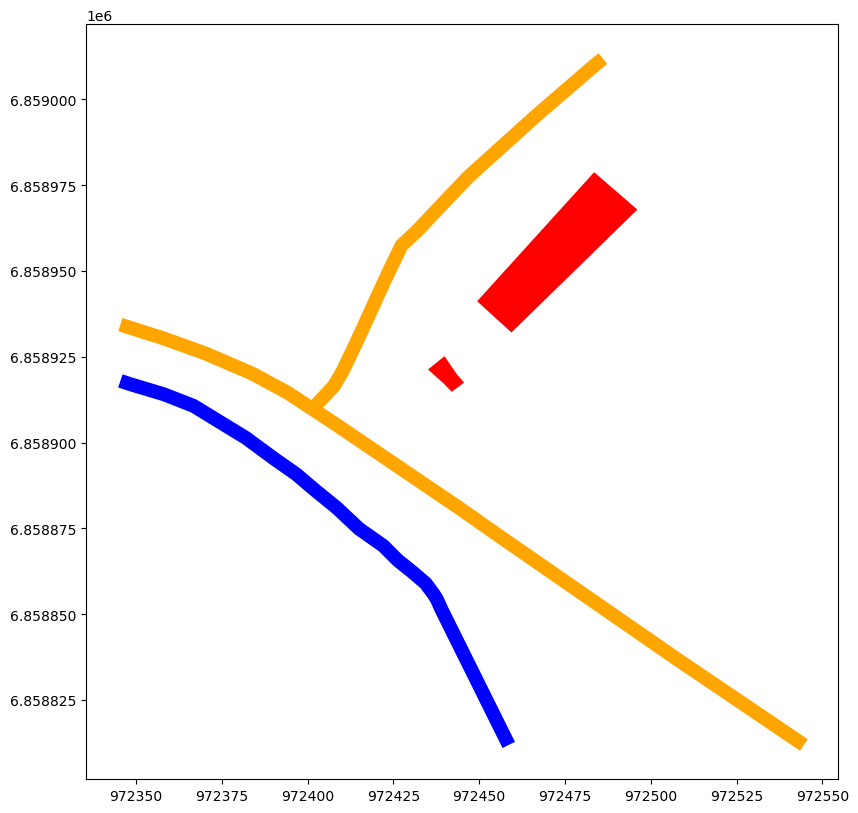

In [22]:
#plt.autoscale(tight=True)
fig, ax = plt.subplots(figsize=(10, 10), dpi=100)
# try:
sg_roads.plot(linewidth=10.0, edgecolor='#FFA500', color='#FFA500', ax=ax)
sg_houses.plot(color='#FF0000', ax=ax)
sg_water.plot(linewidth=10.0, color='#0000FF', ax=ax)
#sg_houses_rem.plot(color='#FFFF00', ax=ax)
#sg_data_rail.plot(linewidth=10.0, color='#FF00FF', ax=ax)
triangles = triangulate(MultiPoint(combined_pd.centroid.tolist()))


C:\Users\mkhokhlova\AppData\Local\Continuum\anaconda3\envs\graphs\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  import sys


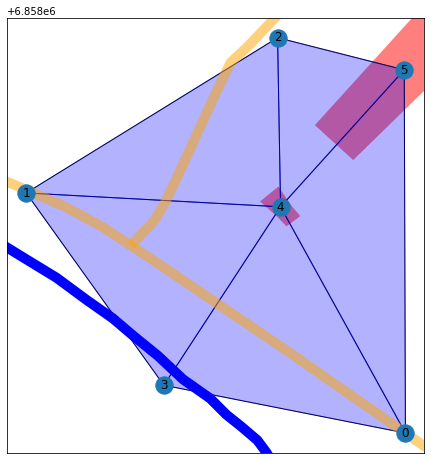

In [24]:
from matplotlib.patches import Polygon as pltPolygon
fig, ax = plt.subplots(figsize=(8, 8))

for p in combined_pd.centroid.tolist():
    ax.scatter(p.x,p.y)
for polygon in triangles:
    mpl_poly = pltPolygon(np.array(polygon.exterior),facecolor="b", color = 'b', lw=1, alpha=0.3)
    ax.add_patch(mpl_poly)
sg_roads.plot(linewidth=10.0, edgecolor='#FFA500', color='#FFA500', alpha = 0.5, ax=ax)
sg_houses.plot(color='#FF0000', alpha = 0.5, ax=ax)
sg_water.plot(linewidth=10.0, color='#0000FF', ax=ax)
#sg_data_rail.plot(linewidth=10.0, color='#FF00FF', ax=ax)
#sg_houses_rem.plot(color='#FFFF00', ax=ax)
nx.draw_networkx(G, pos=pos, with_labels = True, ax = ax) 

ax.relim()
ax.autoscale()

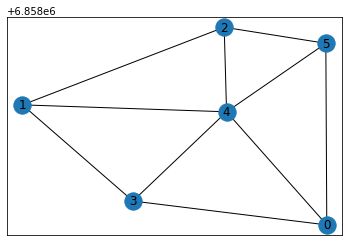

In [25]:
nx.draw_networkx(G, pos=pos, with_labels = True)

# that is it!